<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/3_First_order_methods/A_3_Normalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Appendix A. Advanced First- and Second-Order Optimization Methods

# Normalized Gradient Descent

In the [Section 3.7](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_7_Problems.html) we discussed a fundamental issue associated with the *magnitude* of the negative gradient and the fact that it vanishes near stationary points: gradient descent slowly crawls near stationary points which means - depending on the function being minimized - that it can halt near saddle points.  In this Section we describe a popular enhancement to the standard gradient descent step, called *normalized gradient descent*, that is specifically designed to ameliorate this issue.  The core of this idea lies in a simple inqiury: since the (vanishing) magnitude of the negative gradient is what causes gradient descent to slowly crawl near stationary points / halt at saddle points, what happens if we simply ignore the magnitude at each step by normalizing it out?  In short by normalizing out the gradient magnitude we ameliorate some of the 'slow crawling' problem of standard gradient descent, empowering the method to push through flat regions of a function with much greater ease. 

In [ ]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone library subdirectory
    if not Path('chapter_3_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/3_First_order_methods/chapter_3_library
    else:
        print('chapter_3_library already cloned!')

    # clone videos
    if not Path('chapter_3_videos').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/3_First_order_methods/chapter_3_videos
    else:
        print('chapter_3_videos already cloned!')


# append path for local library, data, and image import
import sys
sys.path.append('./chapter_3_library')
sys.path.append('./chapter_3_videos') 

# import section helper
import section_3_9_helpers
static_plotter = section_3_9_helpers.static_visualizer()
demo_1 = section_3_9_helpers.grad_descent_visualizer()
demo_2 = section_3_9_helpers.grad_descent_visualizer()

# video paths
video_path_1 = 'chapter_3_videos/animation_11.mp4'
video_path_2 = 'chapter_3_videos/animation_12.mp4'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
from base64 import b64encode

def show_video(video_path, width = 1000):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={width} controls><source src="{video_url}"></video>""")

# import autograd-wrapped numpy
import autograd.numpy as np
from autograd import value_and_grad 

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

In [2]:
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha_choice,max_its,w,version):
    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(w)
        cost_history.append(cost_eval)
            
        if version == 'full':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm
        
        # normalize components
        if version == 'component':
            component_norm = np.abs(grad_eval) + 10**(-8)
            grad_eval /= component_norm
            
        if version == 'none':
            grad_eval = grad_eval

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g(w))  
    return weight_history,cost_history

## Normalizing gradient descent

In [Section 3.7](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_7_Problems.html) we saw that the length of a standard gradient descent step is *proportional to the magnitude of the gradient* or, 
in other words, the length of each step is *not* equal to the steplength / learning rate parameter $\alpha$ is given by


\begin{equation}
\text{length of standard gradient descent step:} \,\,\,\, \alpha \, \Vert \nabla g(\mathbf{w}^{k-1}) \Vert_2.
\end{equation}

As we saw it is precisely this fact that explains why gradient descent *slowly crawls* near stationary points, since near such points the gradient vanishes i.e, $\nabla g(\mathbf{w}^{k-1}) \approx \mathbf{0}$.

Since the magnitude of the gradient is to blame for slow crawling near stationary points, what happens if we simply ignore it by normalizing it out of the update step, and just travel in the direction of negative gradient itself?  As we will see below there are several ways of going about doing this.

## Normalizing out the full gradient magnitude

One way to do this is by *normalizing out the full magnitude* of the gradient in our standard gradient descent step, and doing so gives a *normalized gradient descent step* of the form

\begin{equation}
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }
\end{equation}

Doing this we do indeed ignore the magnitude of the gradient, since we can easily compute the length of such a step (provided the magnitude of the gradient is non-zero)

\begin{equation}
\left\Vert \mathbf{w}^{\,k} - \mathbf{w}^{\,k-1} \right\Vert_2 = \left\Vert \left(\mathbf{w}^{\,k-1} - \alpha \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2} \right)    - \mathbf{w}^{\,k-1} \right\Vert_2 = \left\Vert -\alpha \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }\right\Vert_2  = \alpha.
\end{equation}

In other words, if we normalize out the magnitude of the gradient at each step of gradient descent then the length of each step *is exactly equal to the value of our steplength / learning rate parameter* $\alpha$

\begin{equation}
\text{length of fully-normalized gradient descent step:} \,\,\,\, \alpha.
\end{equation}

Notice then that if we slightly re-write the fully-normalized step above as 

\begin{equation}
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \frac{\alpha}{{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }} \nabla g(\mathbf{w}^{\,k-1})
\end{equation}

we can interpret our fully normalized step as a standard gradient descent step with a steplength / learning rate value $\frac{\alpha}{{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }}$ that *adjusts itself at each step based on the magnitude of the gradient to ensure that the length of each step is precisely $\alpha$*.

Also notice that in practice it is often useful to add a small constant $\epsilon$  (e.g., $10^{-7}$ or smaller) to the gradient magnitude to avoid potential division by zero (where the magnitude completely vanishes) 

\begin{equation}
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \frac{\alpha}{{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 } + \epsilon} \nabla g(\mathbf{w}^{\,k-1})
\end{equation}

Below we re-examine the examples of [Section 3.7](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_7_Problems.html) where the slow-crawling problem of standard gradient descent was first diagnosed, only now we employ this fully-normalized gradient descent step.

#### <span style="color:#a50e3e;">Example 1. </span>  Ameliorating the slow-crawling behavior of gradient descent near the minimum of a function

Below we repeat the run of gradient descent first detailed in Example 5 of [Section 3.7](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_7_Problems.html), only here we use a normalized gradient step (both the full and component-wise methods reduce to the same thing here since our function has just a single input).  The function we minimize is 

\begin{equation}
g(w) = w^4 + 0.1
\end{equation}

whose minimum is at the origin $w = 0$.  Here we use the same number of steps and steplength / learning rate value used previously (which led to slow-crawling with the standard scheme).  Here however the normalized step - unaffected by the vanishing gradient magnitude - is able to pass easily through the flat region of this function and find a point very close to the minimum.

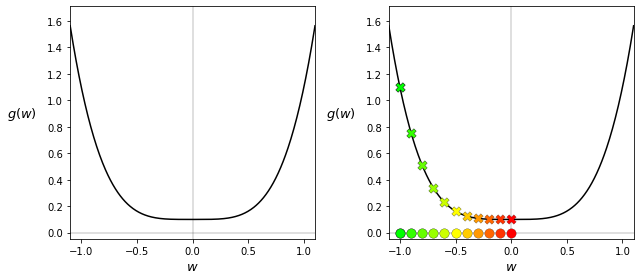

In [3]:
# what function should we play with?  Defined in the next line.
g = lambda w: w**4 + 0.1

# run gradient descent 
w = -1.0; max_its = 10; alpha_choice = 0.1;
version = 'full'
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w,version)

# make static plot showcasing each step of this run
static_plotter.single_input_plot(g,[weight_history],[cost_history],wmin = -1.1,wmax = 1.1)

#### <span style="color:#a50e3e;">Example 2. </span> Slow-crawling behavior of gradient descent near saddle points ameliorated via a normalized step

Here we illustrate how using a normalized descent step helps gradient descent pass easily by a saddle point of the function

\begin{equation}
g(w) = \text{maximum}(0,(3w - 2.3)^3 + 1)^2 + \text{maximum}(0,(-3w + 0.7)^3 + 1)^2
\end{equation}

that would otherwise halt the standard gradient descent method.  This function - which we saw in Example 6 of [Section 3.7](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_7_Problems.html) - has a minimum at $w= \frac{1}{2}$ and saddle points at $w = \frac{7}{30}$ and $w = \frac{23}{30}$.  Here we use the same number of steps and steplength / learning rate value used previously (which led to the standard scheme halting at the saddle point).  Here however the normalized step - unaffected by the vanishing gradient magnitude - is able to pass easily through the flat region of the saddle point and reach a point of this function close to the mininum.

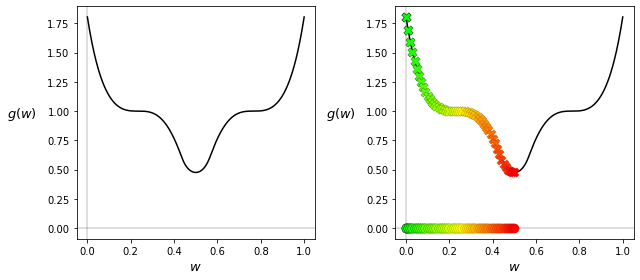

In [4]:
g = lambda w: np.maximum(0,(3*w - 2.3)**3 + 1)**2 + np.maximum(0, (-3*w + 0.7)**3 + 1)**2

# draw function and gradient descent run
demo_1.draw_2d(g=g, w_inits = [0],steplength = 0.01,max_its = 50,version = 'normalized',wmin = 0,wmax = 1.0)

#### <span style="color:#a50e3e;">Example 3. </span> Slow-crawling behavior of gradient descent in large flat regions of a function

Here we use the fully normalized step to minimize

\begin{equation}
g(w_0,w_1) = \text{tanh}(4w_0 + 4w_1) + \text{max}(0.4w_0^2,1) + 1
\end{equation}

initializing our run on a large flat portion of this function.  We saw this example previously in Example 7 of [Section 3.7](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_7_Problems.html) where the standard method was unable to make virtually any progress at all due to the extreme flatness of the area in which we initialize.  Here we use the and steplength / learning rate value used previously (which led to slow-crawling with the standard scheme), but only $100$ steps as opposed to the $1000$ used previously.  Here however the normalized step - unaffected by the vanishing gradient magnitude - is able to pass easily through the flat region of this function and find a point very close to the minimum.

In [ ]:
# define function
g = lambda w: np.tanh(4*w[0] + 4*w[1]) + max(0.4*w[0]**2,1) + 1
w = np.array([1.0,2.0]); max_its = 100; alpha_choice = 10**(-1);
version = 'full'
weight_history_1,cost_history_1 = gradient_descent(g,alpha_choice,max_its,w,version)

# plot contour and weight history
static_plotter.two_input_surface_contour_plot(g,weight_history_1,view = [20,300],num_contours = 20,xmin = -3,xmax = 3,ymin = -5,ymax = 3)

## Normalizing out the magnitude component-wise

Remember that the gradient is a vector of $N$ *partial derivatives* 

\begin{equation}
\nabla g(\mathbf{w}) = \begin{bmatrix} 
\frac{\partial}{\partial w_1}g\left(\mathbf{w}\right) \\
\frac{\partial}{\partial w_2}g\left(\mathbf{w}\right) \\
\vdots \\
\frac{\partial}{\partial w_N}g\left(\mathbf{w}\right) \\
\end{bmatrix}
\end{equation}

with the $j^{th}$ partial derivative $\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)$ defining how the gradient behaves along the $j^{th}$ coordinate axis.

If we then look at what happens to the $j^{th}$ *partial derivative* of the gradient when we normalize off the *full magnitude* 

\begin{equation}
\frac{\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)}{\left\Vert \nabla g\left(\mathbf{w}\right) \right\Vert_2} = \frac{\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)}{\sqrt{\sum_{n=1}^N \left(\frac{\partial}{\partial w_n}g\left(\mathbf{w}\right)\right)^2}}
\end{equation}

we can see that *the $j^{th}$ partial derivative is normalized using a sum of the magnitudes of every partial derivative*.   If the $j^{th}$ partial derivative is already small in magnitude doing this will erase virtually all of its contribution to the final descent step.  This can be problematic when dealing with functions containing regions that are flat with respect to only some of our weights / partial derivative directions, as it *diminishes* the contribution of the very partial derivatives we wish to enhance by ignoring magnitude.

Thus an alternative way to ignore the magnitude of the gradient is to *normalize out the magnitude component-wise*.   So instead of normalizing each partial derivative by the magnitude of the entire gradient, we can normalize each partial derivative with respect to only itself.  Doing this we divide off the magnitude of the $j^{th}$ partial derivative from itself as


\begin{equation}
\frac{\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)}{\sqrt{\left(\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)\right)^2}} = \frac{\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)}{\left|\frac{\partial}{\partial w_j} g\left(\mathbf{w}\right)\right|} = \text{sign}\left(\frac{\partial}{\partial w_j}g\left(\mathbf{w}\right)\right)
\end{equation}

So in the $j^{th}$ direction we can write this component-normalized gradient descent step as

\begin{equation}
w_j^k = w_j^{k-1} - \alpha \, \frac{\frac{\partial}{\partial w_j}g\left(\mathbf{w}^{k-1}\right)}{{\sqrt{\left(\frac{\partial}{\partial w_j}g\left(\mathbf{w}^{k-1}\right)\right)^2}}}.
\end{equation}

or equivalently as 

\begin{equation}
w_j^k = w_j^{k-1} - \alpha \, \text{sign}\left(\frac{\partial}{\partial w_j}g\left(\mathbf{w}^{k-1}\right)\right).
\end{equation}


We can then write the entire component-wise normalized step can be similarly written as e.g.,

\begin{equation}
\mathbf{w}^k = \mathbf{w}^{k-1} - \alpha \, \text{sign}\left(\nabla g\left(\mathbf{w}^{k-1}\right)\right)
\end{equation}

where here the $\text{sign}\left( \cdot \right)$ acts component-wise on the gradient vector.  We can then easily compute the length of a single step of this omponent-normalized gradient descent step (provided the partial derivatives of the gradient are all non-zero) as


\begin{equation}
\left\Vert \mathbf{w}^{\,k} - \mathbf{w}^{\,k-1} \right\Vert_2 = \left\Vert \left(\mathbf{w}^{k-1} - \alpha \, \text{sign}\left(\nabla g\left(\mathbf{w}^{k-1}\right)\right)\right)  - \mathbf{w}^{\,k-1} \right\Vert_2  = \left\Vert -\alpha \, \text{sign}\left(\nabla g\left(\mathbf{w}^{k-1}\right)\right)  \right\Vert_2  = \sqrt{N} \, \alpha
\end{equation}

In other words, if we normalize out the magnitude of gradient component-wise at each step of gradient descent then the length of each step *is exactly equal to the value of our steplength / learning rate parameter* $\alpha$

\begin{equation}
\text{length of component-normalized gradient descent step:} \,\,\,\, \sqrt{N}\,\alpha.
\end{equation}

Notice then that if we slightly re-write the $j^{th}$ component-normalized step $w_j^k = w_j^{k-1} - \alpha \, \frac{\frac{\partial}{\partial w_j}g\left(\mathbf{w}^{k-1}\right)}{{\sqrt{\left(\frac{\partial}{\partial w_j}g\left(\mathbf{w}^{k-1}\right)\right)^2} }}$ equivalently as 

\begin{equation}
w_j^k = w_j^{k-1} - \frac{\alpha}{\sqrt{\left(\frac{\partial}{\partial w_j} g\left(\mathbf{w}^{k-1}\right)\right)^2} } \, \frac{\partial}{\partial w_j}g\left(\mathbf{w}^{k-1}\right).
\end{equation}


we can interpret our component normalized step as a standard gradient descent step with an individual steplength / learning rate value $\frac{\alpha}{\sqrt{\left(\frac{\partial}{\partial w_j} g\left(\mathbf{w}^{k-1}\right)\right)^2}}$ per component that all *adjusts themselves individually at each step based on component-wise magnitude of the gradient to ensure that the length of each step is precisely $\sqrt{N} \, \alpha$*.  Indeed if we write 

\begin{equation}
\mathbf{a}^{k-1} = \begin{bmatrix} 
\frac{\alpha}{\sqrt{\left(\frac{\partial}{(\partial w_1} g\left(\mathbf{w}^{k-1}\right)\right)^2}}  \\
\frac{\alpha}{\sqrt{\left(\frac{\partial}{\partial w_2} g\left(\mathbf{w}^{k-1}\right)\right)^2}}  \\
\vdots \\
\frac{\alpha}{\sqrt{\left(\frac{\partial}{\partial w_N} g\left(\mathbf{w}^{k-1}\right)\right)^2}}  \\
\end{bmatrix}
\end{equation}


then the full component-normalized descent step can also be written as 


\begin{equation}
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \mathbf{a}^{k-1} \odot \nabla g(\mathbf{w}^{\,k-1})
\end{equation}

where the $\odot$ symbol denotes component-wise multiplication.   Again note that this is indeed equivalent to the previously written version of the full component-normalized gradient $
\mathbf{w}^k = \mathbf{w}^{k-1} - \alpha \, \text{sign}\left(\nabla g\left(\mathbf{w}^{k-1}\right)\right)$.  However note in practice if implemented as shown in equation (20) a small $\epsilon > 0$ is added to the denominator of each value of each entry of $\mathbf{a}^{k-1}$ to avoid division by zero. 

#### <span style="color:#a50e3e;">Example 4. </span> Minimizing a function with a flat region along only one dimension

In this example we use the function

\begin{equation}
g(w_0,w_1) = \text{max}\left(0,\text{tanh}(4w_0 + 4w_1)\right) + \text{max}(0,\text{abs}\left(0.4w_0\right)) + 1
\end{equation}

to show the difference between fully and component normalizated steps on a function that has a very narrow flat region along only a single dimension of its input.  Here this function - whose surface and contour plots can be seen in the left and right panels below respectively - is very flat along the $w_1$ direction for any fixed value of $w_0$, and has a very narrow valley leading towards its minima the $w_1$ dimension where $w_0 = 0$.  If initialized at a point where $w_1 > 2$ this function cannot be minimized very easily using standard gradient descent *or* the fully-normalized version.  In the latter case, the magnitude of the partial derivative in $w_1$ nearly zero everywhere, and so fully-normalizing makes this contribution smaller and halts progress.  Below we show the result of $1000$ steps of fully-normalized gradient descent starting at the point $\mathbf{w}^0 = \begin{bmatrix} 2 \\ 2 \end{bmatrix}$, colored green (at the start of the run) to red (at its finale).  As can be seen, little progress is made because the *dircection* provided by the partial derivative in $w_1$ could not be leveraged properly.

In [ ]:
# define function
g = lambda w: np.max(np.tanh(4*w[0] + 4*w[1]),0) + np.max(np.abs(0.4*w[0]),0) + 1
w = np.array([2.0,2.0]); max_its = 1000; alpha_choice = 10**(-1);
version = 'full'
weight_history_1,cost_history_1 = gradient_descent(g,alpha_choice,max_its,w,version)

# plot contour and weight history
static_plotter.two_input_surface_contour_plot(g,weight_history_1,view = [20,280],num_contours = 24,xmin = -3,xmax = 3,ymin = -2,ymax = 3)

In order to make significant progress from this initial point a gradient descent method needs to enhance the minute sized partial derivative in the $w_1$ direction, and one way to do this is via the component-normalization scheme.  Below we show the results of using this version of normalized gradient descent starting at the same initialization and employing the same steplength / learning rate.  Here we only need $50$ steps in order to make significant progress.

In [ ]:
# define function
g = lambda w: np.max(np.tanh(4*w[0] + 4*w[1]),0) + np.max(np.abs(0.4*w[0]),0) + 1

w = np.array([2.0,2.0]); max_its = 50; alpha_choice = 10**(-1);
version = 'component'
weight_history_1,cost_history_1 = gradient_descent(g,alpha_choice,max_its,w,version)

# plot contour and weight history
static_plotter.two_input_surface_contour_plot(g,weight_history_1,view = [20,280],num_contours = 24,xmin = -3,xmax = 3,ymin = -2,ymax = 3)

##  General usage of normalized gradient descent schemes

Normalizing out the gradient magnitude - using either of the approaches detailed above - ameliorates the 'slow crawling' problem of standard gradient descent and empowers the method to push through flat regions of a function with much greater ease.  This includes flat regions of a function that may lead to a local minimum, or the region around a saddle point of a non-convex function where standard gradient descent can halt.  However - as mentioned in [Section 3.7](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_7_Problems.html) - in normalizing every step of standard gradient descent we do *shorten* the first few steps of the run that are typically large (since random initializations are often far from stationary points of a function).  This is the trade-off of the normalized step when compared with the standard gradient descent scheme: we trade shorter initial steps for longer ones around stationary points.

#### <span style="color:#a50e3e;">Example 5.</span>  Normalized vs. unnormalized gradient descent for convex functions 

In this Example we compare fully-normalized and standard gradient descent (left and right panels respectively) on the simple quadratic function

\begin{equation}
g(w)=w^2
\end{equation}

Both algorithms use the same initial point ($w^0 = -3$), steplength parameter ($\alpha = 0.1$), and maximum number of iterations (20 each). Steps are colored from green to red to indicate the starting and ending points of each run, with circles denoting the actual steps in the input space and 'x' marks denoting their respective function evaluations.  

Notice how - due to the re-scaling of each step via the derivative length - the standard version races to the global minimum of the function. Meanwhile the normalized version - taking constant length steps - gets only a fraction of the way there. This behavior is indicative of how a normalized step will fail to leverage the gradient when it is large - as the standard method does - in order to take larger steps at the beginning of a run.

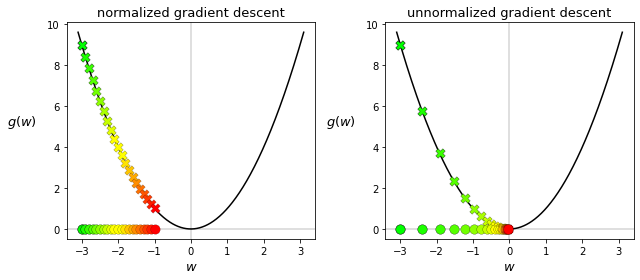

In [8]:
# what function should we play with?  Defined in the next line.
g = lambda w: w**2

# # run the visualizer for our chosen input function, initial point, and step length alpha
# demo = optlib.gradient_descent_demos.visualizer();
demo_2.compare_versions_2d(g=g, w_init = -3,steplength = 0.1,max_its = 20)

##  Normalized steps with respect to vector norms*

The normalized and component-normalzied gradient descent steps described above can be thought of in a unified framework, as *gradient descent directions with respect to different vector norms*.  More specifically, while we saw how the *normalized* step described above is normalized with respect to the $\ell_2$ norm we will see here that the component-normalized step is similarly *normalized* with respect to the $\ell_{\infty}$ vector norm (see the book's appendix for additional information about vector norms).

### Steepest descent direction in the $\ell_2$ norm

When first deriving the gradient descent direction of a multi-input function $g(\mathbf{w})$ at a point $\mathbf{v}$ we began by examining the tangent hyperplane to $g$ at this point

\begin{equation}
h\left(\mathbf{w}\right)=g\left(\mathbf{v}\right)+\nabla g\left(\mathbf{v}\right)^{T}\left(\mathbf{w}-\mathbf{v}\right)
\end{equation} 

We then reasoned out that since in general we know that the *ascent* direction on a hyperplane is given by its set of 'slopes' - stored in $\nabla g(\mathbf{v})$ -  that intuitively therefore the descent direction is given by the negative gradient as $-\nabla g(\mathbf{v})$.  In this Section we further reasoned that we can - in desiring only the *direction* provided by the negative gradient - just as well u normalize it to have unit length as $-\frac{\nabla g(\mathbf{v})}{\left\Vert \nabla g(\mathbf{v}) \right\Vert_2}$. 

This normalized descent direction can also be derived as follows.  Note that $\mathbf{d} = \mathbf{w} - \mathbf{v}$ is a general search direction centered at the point $\mathbf{v}$.  We want to find the unit-length direction $\mathbf{d}$ that provides the smallest evaluation on the hyperplane, i.e., the one that gives the smallest value $g(\mathbf{v}) + \nabla g(\mathbf{v})^T(\mathbf{w} - \mathbf{v}) = g(\mathbf{v}) + \nabla g(\mathbf{v})^T\mathbf{d}$.  Since $\mathbf{d}$ is only present in the second term we only need care about finding the unit length direction $\mathbf{d}$ so that $\nabla g(\mathbf{v})^T\mathbf{d}$ is as small as possible (after all, $g(\mathbf{v})$ is constant).

Formally this is a simple constrained minimization problem

\begin{equation}
\begin{array}{cc}
\underset{\mathbf{d}}{\text{minimize}} & \nabla g(\mathbf{v})^{T}\mathbf{d}\\
\text{subject to} & \left\Vert \mathbf{d}\right\Vert _{2}=1\\
\end{array}
\end{equation}

In the figure below explore possible solutions to this problem in two dimensions for a particular choice of gradient vector, gaining valuable geometric intuition as to what the solution should be.  There we plot an example gradient vector $\nabla g (\mathbf{v})$ as a red arrow, along with the $\ell_2$ unit ball. Moving the slider from left to right you can test various directions $\mathbf{d}$ (each shown as a black arrow) on this $\ell_2$ unit ball computing the inner product $\nabla g(\mathbf{v})^{T}\mathbf{d}$, whose value is simultaneously plotted in the right panel.  As you move the slider right the direction providing the *smallest* value is shown as a green arrow in the left panel, and is highlighted in green in the plot in the right panel.  

/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


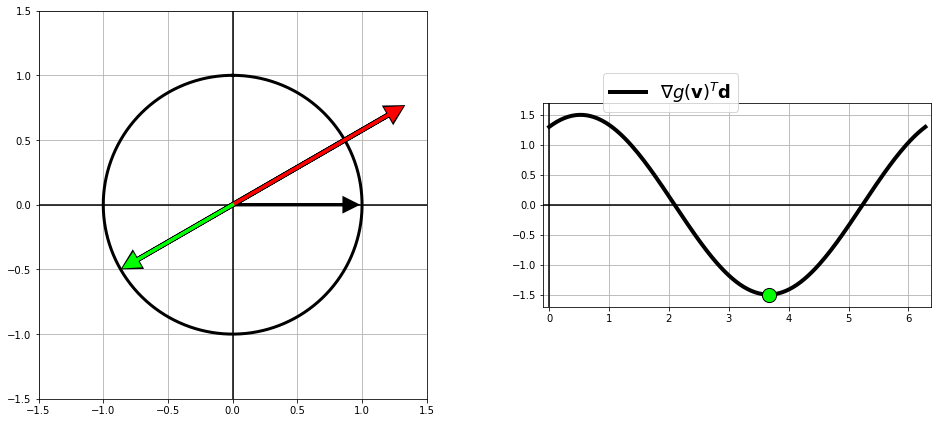

In [9]:
# create an animation showing the origin of the sine and cosine functions
num_frames = 200
pt = [1.3,0.75]
section_3_9_helpers.L2(pt,num_frames,savepath=video_path_1,fps=20)

In [11]:
show_video(video_path_1, width=1000)

As can be seen it appears as if indeed $\mathbf{d} = -\frac{\nabla g(\mathbf{v})}{\left\Vert \nabla g(\mathbf{v}) \right\Vert_2 }$ is the direction producing the smallest inner product.

To prove this formally we can use the *inner product rule* which tells us almost immediately what the solution to this problem is. According to the inner product rule $\nabla g(\mathbf{v})^{T}\mathbf{d}$ can be written as 

$$\nabla g(\mathbf{v})^{T}\mathbf{d} = \left \Vert \nabla g(\mathbf{v}) \right \Vert_2 \left \Vert \mathbf{d} \right \Vert_2 \text{cos}(\theta)$$ 

where $\theta$ is the angle between $\nabla g(\mathbf{v})$ and $\mathbf{d}$.


Noting that both $\left \Vert \nabla g(\mathbf{v}) \right \Vert_2$ and $\left \Vert \mathbf{d} \right \Vert_2$ have constant values (the former is the length of the gradient at $\mathbf{v}$, and latter is just $1$), the value of $\nabla g(\mathbf{v})^{T}\mathbf{d}$ is smallest when $\text{cos}(\theta)$ is smallest, i.e., when $\theta = \pi$. In other words, $\mathbf{d}$ must point in the same direction as $-\nabla g(\mathbf{v})$, and also be unit length. Thus we have $\mathbf{d} = -\frac{\nabla g(\mathbf{v})}{\left \Vert \nabla g(\mathbf{v}) \right \Vert_2}$, that is indeed the normalized gradient descent direction. In deriving the gradient descent direction in this way, $\mathbf{d}$ is referred to more generally as the *steepest descent direction*.

### Steepest descent direction in the $\ell_{\infty}$ norm

Replacing the $\ell_2$ norm with the $\ell_{\infty}$ norm in our original constrained optimization problem above we have a similar looking problem whose solution defines a new kind of steepest descent direction

\begin{equation}
\begin{array}{cc}
\underset{\mathbf{d}}{\text{minimize}} & \nabla g(\mathbf{v})^{T}\mathbf{d}\\
\text{subject to} & \left\Vert \mathbf{d}\right\Vert _{\infty}=1\\
\end{array}
\end{equation}

In the figure below we explore possible solutions to this problem in two dimensions for a particular choice of gradient vector, gaining valuable geometric intuition as to what the solution should be. Here once again we plot an example gradient vector $\nabla g (\mathbf{v})$ as a red arrow, along with the $\ell_{\infty}$ unit ball. Moving the slider from left to right you can test various directions $\mathbf{d}$ (each shown as a black arrow) on this $\ell_{\infty}$ unit ball computing the inner product $\nabla g(\mathbf{v})^{T}\mathbf{d}$, whose value is simultaneously plotted in the right panel. As you move the slider right once more the direction providing the *smallest* value is shown as a green arrow in the left panel, and is highlighted in green in the plot in the right panel.  

/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


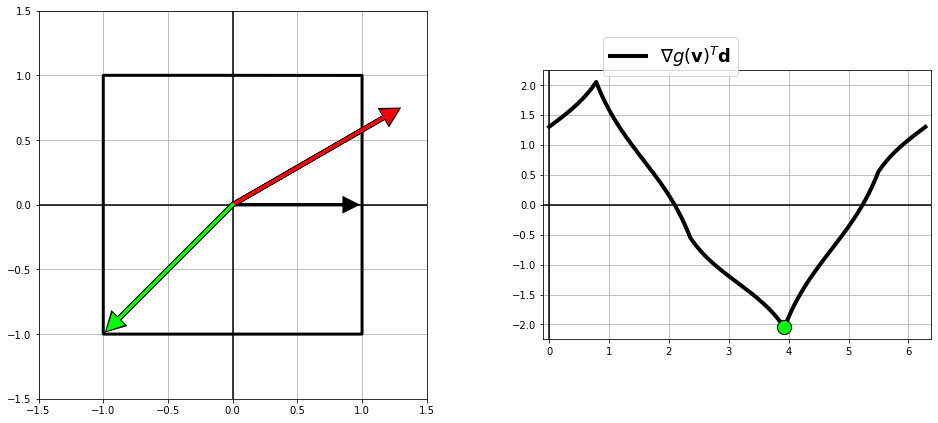

In [12]:
# create an animation showing the origin of the sine and cosine functions
num_frames = 200
pt = [1.3,0.75]
section_3_9_helpers.Linf(pt,num_frames,savepath=video_path_2,fps=20)

In [13]:
show_video(video_path_2, width=1000)

Based on the example above you may now have a hunch about what $\mathbf{d}$ should be. But let's make sure by examining a different gradient vector $\nabla g (\mathbf{v})$.   

Toying around with the slider above it looks as if *each* entry of the descent direction here is the negative unit length partial derivative along its respective coordinate. That is, the $j^{th}$ entry is given as

\begin{equation}
d_j = \frac{ \frac{\partial}{\partial w_j}g(\mathbf{v}) }{\left| \frac{\partial}{\partial w_j}g(\mathbf{v}) \right|} = \text{sign}\left(\frac{\partial}{\partial w_j}g(\mathbf{v})\right)
\end{equation}

and hence the entire descent direction can be written simply as 

\begin{equation}
\mathbf{d} = -\, \text{sign}\left(\nabla g(\mathbf{v}) \right)
\end{equation}

This intuitied formula is in fact correct, and can be proven more rigorously as show in the below.

The steepest descent step at $\mathbf{w}^{k-1}$ in this direction looks like

\begin{equation}
\mathbf{w}^{k} = \mathbf{w}^{k-1} - \alpha\, \text{sign}\left(\nabla g(\mathbf{w}^{k-1}) \right)
\end{equation}

Due to the $\text{sign} (\cdot)$ function these steps tend to be at 'diagonal' traveling largely in directions defined by the corners of the unit square.  

These directions tend to most often be constrainted to the corners of the unit square or - in higher dimensions - the unit hypercube (the exceptions being when one partial derivative is exactly equal to zero).  Moreover, this is precisely the *component-normalized gradient descent direction* we saw above.  So indeed the component-normalized step can be equally thought of as a fully normalized gradient descent step taken with respect to the $\ell_{\infty}$ vector norm.

To formally prove that this direction is indeed the optimal solution to the constrained problem above, we can examine its mirror *maximization* problem for the *ascent* direction

\begin{equation}
\begin{array}{cc}
\underset{\mathbf{d}}{\text{maximize}} & \mathbf{a}^{T}\mathbf{d}\\
\text{subject to} & \left\Vert \mathbf{d}\right\Vert _{\infty}=1\\
\end{array}
\end{equation}

written entry-wise as

\begin{equation}
\begin{array}{cc}
\underset{d_1,\,d_2,\,\ldots,\, d_n}{\text{maximize}} & a_1d_1+a_2d_2+\cdots+a_nd_n\\
\text{subject to} & \text{max}\left\{ \left|d_{1}\right|,\,\left|d_{2}\right|,\,\ldots,\,\left|d_{n}\right|\right\} =1\\
\end{array}
\end{equation}

Notice that the constraint set 

$$\mathcal{S}=\left\{ \mathbf{d}\left|\text{ max}\left(\left|d_{1}\right|,\,\left|d_{2}\right|,\,\ldots,\,\left|d_{n}\right|\right)=1\right.\right\}$$

is a subset of the set 

$$\mathcal{T}=\left\{ \mathbf{d}\left|\, -1\leq d_{1},\,d_{2},\,\ldots,\,d_{n}\leq1\right.\right\}$$

Therefore the maximum objective value subject to $\mathbf{d}\in\mathcal{S}$ is upperbounded by the maximum objective value subject to $\mathbf{d}\in\mathcal{T}$. The latter problem can be then written as

\begin{equation}
\begin{array}{cc}
\underset{d_1,\,d_2,\,\ldots,\, d_n}{\text{maximize}} & a_1d_1+a_2d_2+\cdots+a_nd_n\\
\text{subject to} & -1\leq d_{i}\leq1,\;\forall i \\
\end{array}
\end{equation}

Now note that this problem can be broken down into $n$ independent optimization problems of the form 

\begin{equation}
\begin{array}{cc}
\underset{d_i}{\text{maximize}} & a_id_i\\
\text{subject to} & -1\leq d_{i}\leq1 \\
\end{array}
\end{equation}

with the easily calculable solution given as $d_i^{\star}=\text{sign}(a_i)$. Taken all together

\begin{equation}
\mathbf{d}^{\star}=\text{sign}(\mathbf{a})
\end{equation}

maximizes the objective subject to $\mathbf{d}\in\mathcal{T}$. Given we have that $\mathbf{d}^{\star}\in\mathcal{S}$ as well, $\mathbf{d}^{\star}$ also maximizes the objective subject to $\mathbf{d}\in\mathcal{S}$.  This of course means that the *descent direction* is precisely what we derived intuitively, i.e., the component-normalized gradient descent direction.